# Проект по проведению A/B тестирования в интернет-магазине

Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Наша задача**

- приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

В конечном итоге по полученным результатам мы должны решить:
1. Остановить тест, зафиксировать победу одной из групп
2. Остановить тест, зафиксировать отсутствие различий между группами
3. Продолжить тест.

## Обзор данных

Импортируем нужные библотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Загрузим нужные нам данные:

In [2]:
# данные с оценками и описанием гипотез
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

# данные о заказах
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])

# данные о пользователях
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

Описание данных:

**Структура `hypothesis.csv`**
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Структура `orders.csv`**
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

**Структура `visitors.csv`**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Посмотрим общую информацию по каждому датасету

In [3]:
# создадим функцию для удобства просмотра общей информации по каждому датафрейму
def df_info(df):    
    df.info()
    display(df.head())
    print('Количество дубликатов:', df.duplicated().sum())
    display('Количество пропусков', df.isna().sum())

In [4]:
df_info(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Количество дубликатов: 0


'Количество пропусков'

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [5]:
df_info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Количество дубликатов: 0


'Количество пропусков'

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [6]:
df_info(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Количество дубликатов: 0


'Количество пропусков'

date        0
group       0
visitors    0
dtype: int64

Дубликатов и пропусков нет, каждый столбец соответствует своему формату. Для эстетичности приведем названия столбцов к нижнему регистру в нужных датасетах.

In [7]:
# методом lower приведем названия столбцов к рабочему виду
hypothesis.columns = hypothesis.columns.str.lower()

In [8]:
# методом rename приведем названия столбцов к рабочему виду
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId': 'visitor_id'})

Проверим, что все названия столбцов находятся в нижнем регистре.

In [9]:
list_df = [hypothesis, orders, visitors]

In [10]:
for df in list_df:
    display(df.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Index(['date', 'group', 'visitors'], dtype='object')

Проверим те данные на выбросы, где они могут быть:

In [11]:
orders.revenue.describe().round(2).to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,1197.0,8348.01,39191.13,50.0,1220.0,2978.0,8290.0,1294500.0


Видим, что среднее и медианное значения достаточно сильно разнятся. Можем заметить, что в 75 % случаев выручка заказа не превышает значения `8290`. Это может говорить о том, что есть достаточно дорогие заказы, которые могут смещать среднее распределение выручки.

In [12]:
visitors.visitors.describe().round(2).to_frame().T

,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.29,114.4,361.0,534.0,624.5,710.5,770.0


Каких-то аномальных всплесков в количестве посетителей не выявлено.

## Приоритизация гипотез

Проведем приоритизацию поставленных перед нами гипотез. Посчитаем `ICE` и `RICE`.

In [13]:
# посмотрим общую картину по датасету
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Добавим столбец с нумерацией гипотез, чтобы было проще воспринимать полученные результаты.

In [14]:
# создадим список с нумерацией значений для гипотезы и добавим столбец
hyp_num = ['hyp_1', 'hyp_2', 'hyp_3', 'hyp_4', 'hyp_5', 'hyp_6', 'hyp_7', 'hyp_8', 'hyp_9']
hypothesis['hyp_number'] = hyp_num

Посчитаем `ICE`:

In [15]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)

In [16]:
hypothesis[['hyp_number', 'ICE']].sort_values(by='ICE', ascending=False)

,hyp_number,ICE
8,hyp_9,16.20
0,hyp_1,13.33
7,hyp_8,11.20
6,hyp_7,8.00
2,hyp_3,7.00
1,hyp_2,2.00
5,hyp_6,1.33
3,hyp_4,1.12
4,hyp_5,1.00


Изучив таблицу, видим, что наиболее перспективные гипотезы по ICE: 9, 1 и 8.

Посчитаем `RICE`:

In [17]:
hypothesis['RICE'] = round(hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'] / hypothesis['efforts'], 2)

In [18]:
hypothesis[['hyp_number', 'RICE']].sort_values(by='RICE', ascending=False)

,hyp_number,RICE
7,hyp_8,112.0
2,hyp_3,56.0
0,hyp_1,40.0
6,hyp_7,40.0
8,hyp_9,16.2
3,hyp_4,9.0
1,hyp_2,4.0
5,hyp_6,4.0
4,hyp_5,3.0


По оценке `RICE` наш топ немного поменялся, наиболее перспективными являются: 8, 3 и 1. Как мы видим, гипотеза №9 упала в середину списка. Она всем хороша, кроме одного критерия: у неё максимально маленький охват пользователей, что не даст нам получить достоверного результата по итогу А/В-теста. Делаем вывод, что кроме силы гипотезы, нужно учитывать и то, сколько пользователей она затронет и выявлять приоритет гипотезы, учитывая этот фактор.

In [19]:
print('Поэтому для А/В-теста самой перспективной гипотезой можно назвать гипотезу №8:', hypothesis.loc[7]['hypothesis'])

Поэтому для А/В-теста самой перспективной гипотезой можно назвать гипотезу №8: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


## Анализ A/B-теста

Создадим датафрейм `dates_groups` с уникальными парами значений `date` и `group`. Удалим дубликаты.

In [20]:
dates_groups = orders[['date','group']].drop_duplicates()

In [21]:
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Объявим переменную `orders_aggregated`, которая содержит:

- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

Сделаем сортировку по дате и группе.

In [22]:
orders_aggregated = dates_groups\
    .apply(lambda x: orders[np.logical_and(
    orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),
           axis=1)\
    .sort_values(by=['date','group'])

In [23]:
orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Объявим переменную `visitors_aggregated`, которая содержит:

- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

Сделаем сортировку по дате и группе.

In [24]:
visitors_aggregated = dates_groups\
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

In [25]:
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объявим переменную `cumulative_data`, объединив вышесозданные таблицы, агрегированные по заказам и пользователям, методом `merge()` по колонкам даты и группы.

In [26]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [27]:
cumulative_data.head()

,date,group,transaction_id,visitor_id,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Объявим переменные `cumulative_revenue_A` и `cumulative_revenue_B`, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

In [28]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'transaction_id']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'transaction_id']]

In [29]:
cumulative_revenue_A.head()

,date,revenue,transaction_id
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [30]:
cumulative_revenue_B.head()

,date,revenue,transaction_id
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


Построим графики кумулятивной выручки по группам по дням.

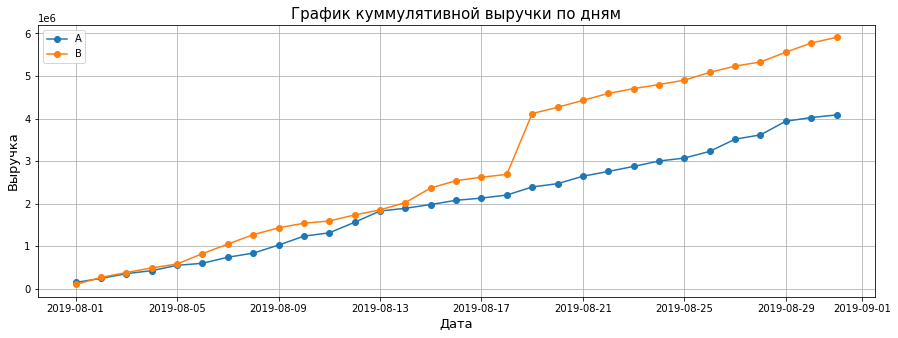

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A', marker='o')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B', marker='o')
plt.grid()
plt.xlabel('Дата', size=13)
plt.ylabel('Выручка', size=13)
plt.title('График куммулятивной выручки по дням', size=15)
plt.legend()
plt.show()

Как мы можем видеть на графике, группа А и группа В шли примерно на одном уровне. Группа Б немного опережала Группу А по сумме выручки, но вцелом, примерно одинаково. С 18 августа 2019 г. произошел резкий скачок вверх по выручке в группе Б. Могут быть предположения, что либо произошел наплыв покупателей (акции, скидки, рекламная компания и т.п.), либо были совершены достаточно дорогие заказы. 

Для каждой группы построим графики кумулятивного среднего чека по дням.

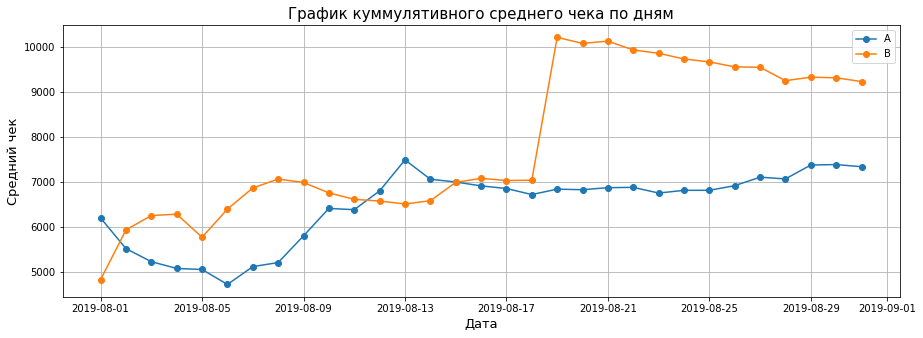

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['transaction_id'], label='A', marker='o')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['transaction_id'], label='B', marker='o')
plt.grid()
plt.xlabel('Дата', size=13)
plt.ylabel('Средний чек', size=13)
plt.title('График куммулятивного среднего чека по дням', size=15)
plt.legend()
plt.show()

Видим похожую ситуацию, как и с выручкой. Средний чек группы В показывал себя лучше (отдавая преимущество только 1-го и 13-го августа), но основной скачок так же произошел 18 августа. В начале просмотра данных, мы видели, что присутствуют достаточно дорогие заказы в общей таблице, нужно будет подробнее ознакомиться с выбросами.

Далее объединим таблицы с куммулятивными расчетами групп А и В методом `merge()`. Сохраним в переменной `merged_cumulative_revenue`.

In [33]:
merged_cumulative_revenue = cumulative_revenue_A\
    .merge(cumulative_revenue_B, left_on='date', right_on='date', how='left')

In [34]:
# переименуем названия столбцов
merged_cumulative_revenue.columns = ['date', 'revenue_A', 'order_id_A', 'revenue_B', 'order_id_B']

In [35]:
merged_cumulative_revenue.head()

,date,revenue_A,order_id_A,revenue_B,order_id_B
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим график относительно различия кумулятивного среднего чека группы B к группе A.

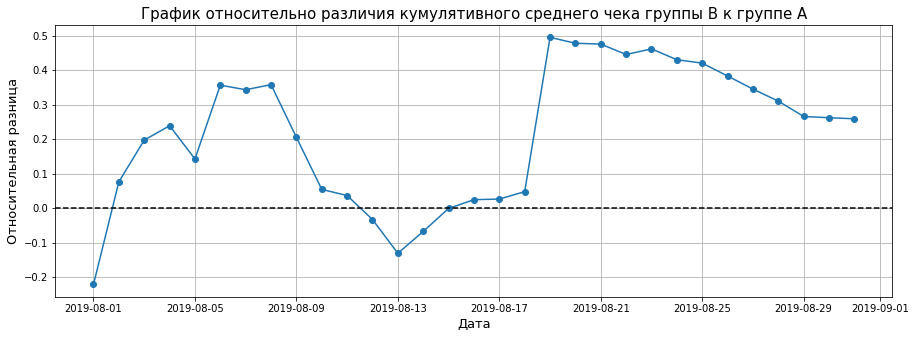

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_revenue['date'],\
         (merged_cumulative_revenue['revenue_B']/merged_cumulative_revenue['order_id_B'])\
         /(merged_cumulative_revenue['revenue_A']/merged_cumulative_revenue['order_id_A'])-1, marker='o')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.xlabel('Дата', size=13)
plt.ylabel('Относительная разница', size=13)
plt.title('График относительно различия кумулятивного среднего чека группы B к группе A', size=15)
plt.show()

По данному графику можем сделать вывод, что в большинстве дней группа В показывает себя лучше, чем группа А по среднему чеку, что мы, в принципе, видели и на предыдущем графике. Есть просадки, когда группа А была получше, это 1-го и 13-го августа. Так же видно резкое увеличение среднего чего 18 августа.

Добавим в `cumulative_data` столбец `conversion` c отношением числа заказов к количеству пользователей в указанной группе в указанный день.
Объявим переменные `cumulative_data_A` и `cumulative_data_B`, в которых сохраните данные о заказах в сегментах A и B соответственно.

In [37]:
cumulative_data['conversion'] = cumulative_data['transaction_id']/cumulative_data['visitors']

In [38]:
cumulative_data.head()

,date,group,transaction_id,visitor_id,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [39]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

Построим графики кумулятивной конверсии по дням по группам.

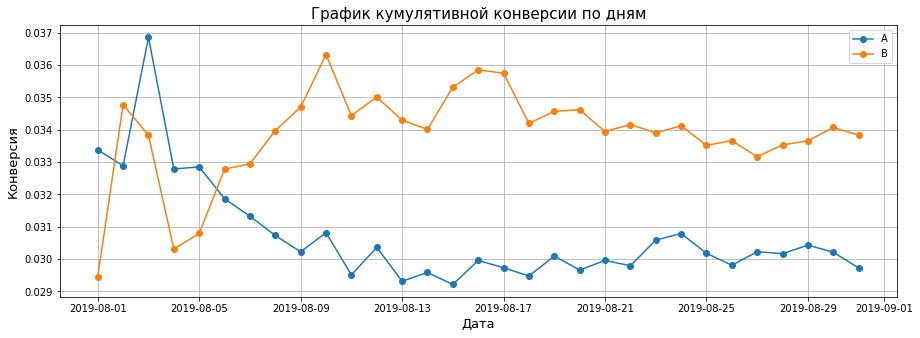

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A', marker='o')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B', marker='o')
plt.grid()
plt.xlabel('Дата', size=13)
plt.ylabel('Конверсия', size=13)
plt.title('График кумулятивной конверсии по дням', size=15)
plt.legend()
plt.show()

Как мы видим, первые дни группа А опережала по конверсии группу В, уступив лишь 2 августа. Но начиная с 6 августа группа В уверенно заняла лидирующие позиции по количеству заказов относительно пришедших клиентов. Начиная с 9-10 августа обе группы вышли на относительную стабильность по конверсии. 

Объедините таблицы `cumulative_data_A` и `cumulative_data_B` методом `merge()`, и сохраним в переменную `merged_cumulative_conversions`.

In [41]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']]\
    .merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left')

In [42]:
# изменим названия столбцов
merged_cumulative_conversions.columns = ['date', 'conversion_A', 'conversion_B']

In [43]:
merged_cumulative_conversions.head()

,date,conversion_A,conversion_B
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Построим график относительного различия кумулятивной конверсии группы B к группе A.

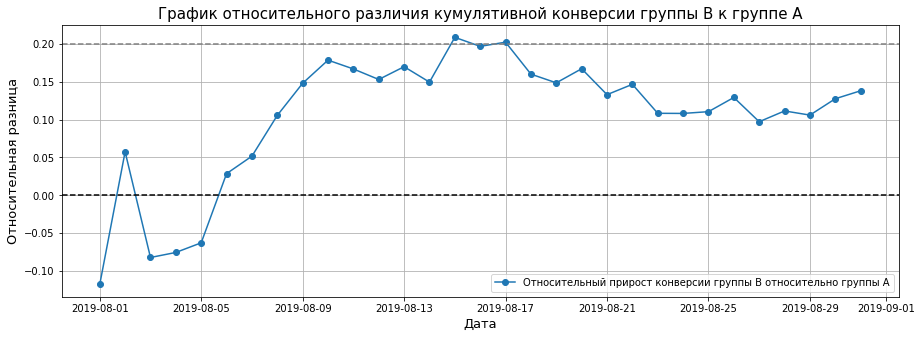

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_conversions['date'],\
         merged_cumulative_conversions['conversion_B']/merged_cumulative_conversions['conversion_A']-1,\
         label="Относительный прирост конверсии группы B относительно группы A", marker='o')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.grid()
plt.xlabel('Дата', size=13)
plt.ylabel('Относительная разница', size=13)
plt.title('График относительного различия кумулятивной конверсии группы B к группе A', size=15)
plt.legend()
plt.show()



Как и по предыдущему графику, видим что рост конверсии в группе В относительно группы А уверенно начался с 6 августа. В моменте с 15 по 17 августа это прирост составил 20 %, но уже 18 августа начал снижаться. По последним данным известно, что минимальная точка падения 27 августа достигла отметки прироста в 10 %, но с 28 августа опять потихоньку начался рост к 15 % прироста конверсии группы В относительно группы А. 

Какие-либо окончательные выводы пока делать рано.

Далее найдем число заказов по пользователям — сгруппируем датафрейм по пользователям и посчитаем количество уникальных заказов. Назовем его `orders_by_users`.

In [45]:
orders_by_users = (orders.groupby('visitor_id', as_index=False)
                .agg({'transaction_id': 'nunique'}))

In [46]:
orders_by_users.sort_values(by='transaction_id', ascending=False).head(10)

,visitor_id,transaction_id
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Построим диаграмму методом `scatter()`. Так мы сможем наглядно увидеть, сколько заказов регулярно делает каждый пользователь. 

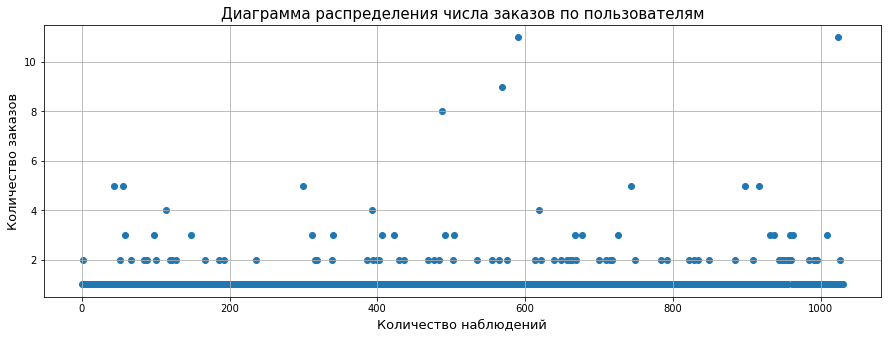

In [47]:
# серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.grid()
plt.xlabel('Количество наблюдений', size=13)
plt.ylabel('Количество заказов', size=13)
plt.title('Диаграмма распределения числа заказов по пользователям', size=15)
plt.show()

Как мы видим, преимущественно пользователи делают заказ один раз. Уже гораздо реже делают 2 раза, и совсем редко более 2 раз. Чтобы ещё более точечно взглянуть на это, посчитаем 90-й, 95-й и 99-й выборочные перцентили количества заказов по пользователям методом `np.percentile()`.

In [48]:
np.percentile(orders_by_users['transaction_id'], [90, 95, 99])

array([1., 2., 4.])

Можем наблюдать, что не более 5% пользователей делают заказ более 2-х раз и не более 1% пользователей делают заказ более 4-х раз. Поэтому можем отметить границу для аномальных пользователей, которые делали заказы более 2-х раз. 

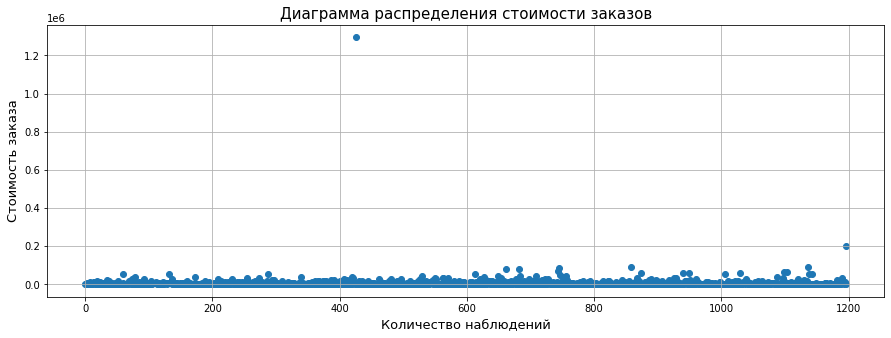

In [49]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.xlabel('Количество наблюдений', size=13)
plt.ylabel('Стоимость заказа', size=13)
plt.title('Диаграмма распределения стоимости заказов', size=15)
plt.show()

На графике отчетливо видим, что абсолютное большинство заказов примерно до 80 тыс. Есть очевидный выброс заказа дороже 1.2 млн, и одинокий заказ за 200 тыс. Чтобы более точно увидеть цифры, так же воспользуемся методом `np.percentile()`.

In [50]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Как мы видим, не более 5% заказов дороже 28 тыс. и не более 1 % заказов дороже 58 тыс. Поэтому всё, что дороже 28 тыс. можно определить как аномалии.

В дальнейших шагах мы будем рассчитывать статистическую значимость для "сырых" данных (без удаления аномальных значений) и для "очищенных" данных (с удалением аномальных значений). 

### Расчет статистической значимости по "сырым" данным.

Соберем все данные по заказам и визитам (а также добавим кумулятивные показатели) в одну таблицу. Для этого создадим несколько таблиц и затем объединим их:

In [51]:
# определим количество пользователей в выбранную дату в группе A
visitors_A_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

# определим количество пользователей до выбранной даты включительно в группе A
visitors_A_cummulative = visitors_A_daily.apply(lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitors_per_date_A' : 'sum'}), axis=1)
visitors_A_cummulative.columns = ['date', 'visitors_A_cummulative']

# определим количество пользователей в выбранную дату в группе В
visitors_B_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

# определим количество пользователей до выбранной даты включительно в группе В
visitors_B_cummulative = visitors_B_daily.apply(lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitors_per_date_B' : 'sum'}), axis=1)
visitors_B_cummulative.columns = ['date', 'visitors_B_cummulative']


# определим  количество заказов и  суммарную выручку в выбранную дату в группе A
orders_A_daily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# определим суммарное число заказов и суммарную выручку до выбранной даты включительно в группе A
orders_A_cummulative = orders_A_daily.apply(
    lambda x: \
        orders_A_daily[orders_A_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_A' : 'sum',
                'revenue_per_date_A' : 'sum'}), axis=1).sort_values(by=['date'])
orders_A_cummulative.columns = ['date', 'orders_cummulative_A', 'revenue_cummulative_A']

# определим  количество заказов и  суммарную выручку в выбранную дату в группе В
orders_B_daily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# определим суммарное число заказов и суммарную выручку до выбранной даты включительно в группе В
orders_B_cummulative = orders_B_daily.apply(
    lambda x: \
        orders_B_daily[orders_B_daily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_B' : 'sum',
                'revenue_per_date_B' : 'sum'}), axis=1).sort_values(by=['date'])
orders_B_cummulative.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

Теперь соединим все составленные таблицы методом `merge()` в один датасет:

In [52]:
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

In [53]:
data.head()

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_A_cummulative,visitors_B_cummulative
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим переменные `orders_by_users_A` и `orders_by_users_B`, где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов.

In [54]:
# заказы пользователей из группы А
orders_by_users_A = (orders[orders['group'] == 'A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id': 'nunique'}))

orders_by_users_A.head()

,visitor_id,transaction_id
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [55]:
# заказы пользователей из группы В
orders_by_users_B = (orders[orders['group'] == 'B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id': 'nunique'}))

orders_by_users_B.head()

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [56]:
# список индексов создадим функцией np.arange() и объединими последовательности функцией pd.concat()
sample_A = pd.concat([orders_by_users_A['transaction_id'],pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['transaction_id'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['transaction_id'],pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['transaction_id'])), name='orders')],axis=0)

Далее применим тест Манна-Уитни. Сформулируем гипотезы:
- Н0 - Статистически значимых различий в конверсии между группами нет
- Н1 - Статистически значимые различия в конверсии между группами есть

In [57]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print("Относительное различие 'B' и 'A' = {0:.3f}".format(sample_B.mean()/sample_A.mean()-1)) 

alpha = 0.05
p-value = 0.017
Относительное различие 'B' и 'A' = 0.138


Видя результаты, что `p-value` меньше, чем `alpha`, можем сказать, что нулевую гипотезу мы отвергаем. Статистически значимые различия в конверсии между группами есть. По "сырым" данным, в конверсии, группа В выигрывает над группой А на 13,8 %.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами:

- Н0 - Различий в среднем чеке между группами нет
- Н1 - Различия в среднем чеке между группами есть

In [58]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительное различие 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
p-value = 0.729
Относительное различие 'B' и 'A' = 0.259


Видим, что `p-value` значительно больше, чем `alpha`. Значит нулевую гипотезу мы не отвергаем. Статистически значимых различий в среднем чеке между группами нет. По "сырым" данным, в среднем чеке, группа В выигрывает над группой А на 25,9 %. Вероятно это связано с аномалиями, которые присутствуют в "сырых" данных.

### Расчет статистической значимости по "очищенным" данным.

Выше по проекту мы определили, что "нормальными" пользователями (без аномальных значений), мы обозначили тех, кто не совершал более 2-х покупок и кто совершал заказ не более, чем на 28 тыс. Поэтому для начала вычислим, сколько же у нас аномальных пользователей.

In [59]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['transaction_id'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['transaction_id'] > 2]['visitor_id'],
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.head(5))
print( "Количество аномальных пользователей:", abnormal_users.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
Количество аномальных пользователей: 74


Далее подготовим отфильтрованные выборки количества заказов по пользователям по группам теста:

In [60]:
sample_A_filtered = pd.concat(
    [orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['transaction_id']) ),
            name='orders', ), ], axis=0,)

sample_B_filtered = pd.concat(
    [ orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['transaction_id'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['transaction_id'])),
            name='orders',), ], axis=0,)

Далее применим тест Манна-Уитни уже на очищенные данные. Сформулируем гипотезы:
- Н0 - Статистически значимых различий в конверсии между группами нет
- Н1 - Статистически значимые различия в конверсии между группами есть

In [61]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print("Относительное различие 'B' и 'A' = {0:.3f}".format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

alpha = 0.05
p-value = 0.013
Относительное различие 'B' и 'A' = 0.173


Видя результаты, что `p-value` меньше, чем `alpha`, можем сказать, что нулевую гипотезу мы так же отвергаем, как и с "сырыми" данными. Статистически значимые различия в конверсии между группами так же есть. По "очищенным" данным, в конверсии, группа В выигрывает над группой А на 17,3 %. Больше чем по "сырым" данным (13,8%).

Далее посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей.

- Н0 - Различий в среднем чеке между группами нет
- Н1 - Различия в среднем чеке между группами есть

In [62]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(
        stats.mannwhitneyu(
            orders[np.logical_and( orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)), )]['revenue'],)[1]))

print("Относительное различие 'B' и 'A' = {0:.3f}".format(
        orders[np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean() 
                / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean()- 1))

alpha = 0.05
p-value = 0.738
Относительное различие 'B' и 'A' = -0.020


Видим, что `p-value` значительно больше, чем `alpha`, как и в "сырых" данных. Значит нулевую гипотезу мы не отвергаем. Статистически значимых различий в среднем чеке между группами нет. Но по "очищенным" данным, в среднем чеке, группа В немного уступает группе А (2 %). Это вероятно и связано с той самой аномалией, которая присутствует в "сырых" данных (покупка более чем на 1.2 млн).

## Выводы по результатам теста

Можем считать, что тест произведен успешно и закончить его.

- Конверсия из пользователя в покупателя в группе В, статистически более значимо и выше, чем в группе А, как по "сырым" (13,8%) , так и по "очищенным" данным (17,3%)
<br>

- Так же было выяснено, что средний чек по заказам в обеих группах практически не отличается. По "очищенным" данным средний чек группы В был пониже на 2% среднего чека группы А, причиной которой является аномальный заказ более, чем на 1,2 млн по "сырым" данным (там отличие было на 25,9% относительно группы А)
<br>

Итоговый вывод: группа В эффективнее чем группа А по конверсии из пользователя в покупателя, что потенциально дает гораздо большую вероятность увеличения среднего чека, хоть и в данном эксперименте средние чеки фактически не имеют различий.